**ORIE 4740 Final Project <br />
Brian Bao // Peter Li** 

In [20]:
import time
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import plotly.offline as py
py.init_notebook_mode(connected=True)
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import accuracy_score, classification_report, fbeta_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing

In [5]:
data = pd.read_csv('nba_player_year.csv')
data.index = data['name']
data.drop(['name'], axis=1, inplace=True)
y_cl = data['salary_bucket']
y = data['salary']
x = data.drop(['salary', 'salary_bucket'], axis=1)
x = (x - x.min())/(x.max() - x.min())
x.head()

,year,ast,blk,dreb,ft_p,oreb,per,pf,pts,stl,three_p,to,ts,two_p
name,,,,,,,,,,,,,,
a.c. green,0.000000,0.060997,0.068452,0.344639,0.738,0.443709,0.609181,0.315364,0.264831,0.241803,0.200,0.213362,0.522556,0.507
a.c. green,0.038462,0.100515,0.107143,0.498906,0.744,0.675497,0.645161,0.380054,0.394068,0.372951,0.214,0.239224,0.522556,0.495
a.c. green,0.076923,0.099656,0.116071,0.463895,0.739,0.633554,0.640199,0.401617,0.371116,0.360656,0.348,0.250000,0.566729,0.550
a.c. green,0.115385,0.117698,0.113095,0.522976,0.735,0.607064,0.648883,0.382749,0.425141,0.286885,0.229,0.215517,0.521617,0.513
a.c. green,0.153846,0.109107,0.092262,0.519694,0.732,0.428256,0.614144,0.393531,0.323446,0.225410,0.339,0.245690,0.560150,0.547


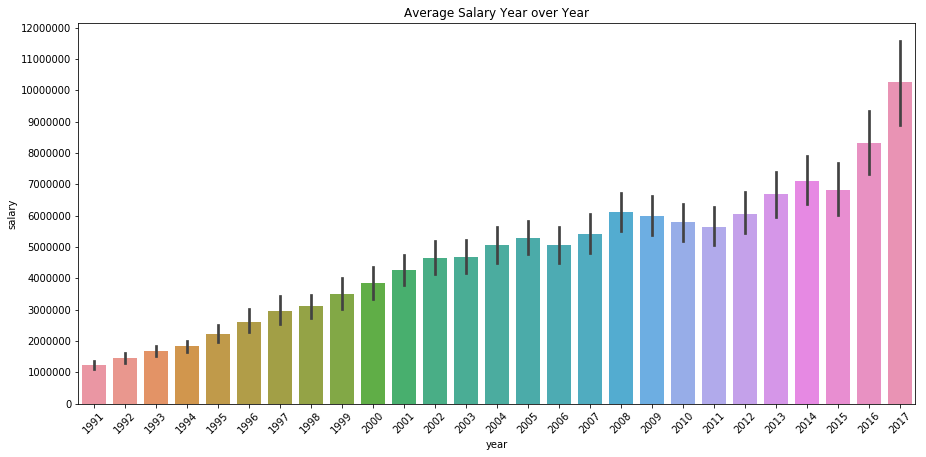

In [6]:
# sns.countplot(x='rating_category', data=data).set_title("Chocolate")

# sns.countplot(x='quality_category', data=data).set_title("White Wine")
# plt.figure(figsize=[3,3])
# sns.barplot(x = 'quality_category', y = 'sulphates', data = data).set_title("White Wine")
# sns.barplot(x = 'quality_category', y = 'pH', data = data).set_title("White Wine")

# plt.xticks(rotation=45)
# sns.countplot(x='cocoa_pct', data=data)

# fig, ax = plt.subplots(figsize=[13,4])
# for i, c in data.groupby('is_domestic'):
#     sns.distplot(c['rating_category'], ax=ax, label=['Not Domestic', 'Is Domestic'][i])

# ax.set_title('Categorized Rating, Domesticity')
# ax.legend()
# plt.xlabel("Categorized Rating")
# plt.ylabel("Count")
plt.figure(figsize=(15,7))
plt.xticks(rotation=45)
plt.yticks(range(0, 10**8, 10**6))
plt.ticklabel_format(style='plain', axis='y')
sns.barplot(x='year', y='salary', data=data).set_title("Average Salary Year over Year")

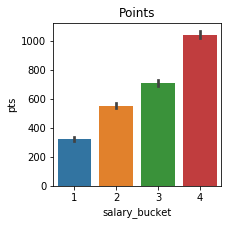

In [29]:
# sns.countplot(x='salary_bucket', data=data).set_title("Binned Salary")
plt.figure(figsize=[3,3])
sns.barplot(x = 'salary_bucket', y = 'pts', data = data).set_title("Points")


In [ ]:
def data_sort(x, y):
    idx = x.argsort()
    return x[idx], y[idx]

In [80]:
def plot_results(y_preds, yTe):
    fig, ax = plt.subplots(figsize=(10, 5))
    yTe, y_preds = data_sort(yTe, y_preds)
    ax.plot(yTe, 'blue')
    ax.plot(y_preds, 'r.')
    ax.autoscale_view()
    ax.grid = True

def predict(model, sample_size, xTr, yTr, xTe, yTe):
    '''
        params:
        - model: model to fit
        - sample_size: number of samples to size
        - xTr: training features
        - yTr: training labels
        - xTe: testing features
        - yTe: testing labels
    '''
    print("Training {} on {} samples".format(model.__class__.__name__, sample_size))
    results = {}
    
    start = time.time()
    model = model.fit(xTr[:sample_size], yTr[:sample_size])
    end = time.time()

    results['train_time'] = end - start
    
    start = time.time()
    train_preds = model.predict(xTr[:300])
    test_preds = model.predict(xTe)
    end = time.time()
    
    results['prediction_time'] = end - start
    
    # Score by accuracy 1(pred_i != yTe_i)
    results['acc_train'] = accuracy_score(yTr[:300], train_preds)
    results['acc_test'] = accuracy_score(yTe, test_preds)

    # Score by fbeta 
    results['f_train'] = fbeta_score(yTr[:300], train_preds, beta=0.5, average='micro')
    results['f_test'] = fbeta_score(yTe, test_preds, beta=0.5, average='micro')
    print(classification_report(yTe, test_preds))

    if model.__class__.__name__ == "RandomForestClassifier":
        try:
            importances = model.feature_importances_

            std = np.std([tree.feature_importances_ for tree in model.estimators_],
                         axis=0)
            indices = np.argsort(importances)[::-1]

            plt.figure(figsize=(10,5))
            plt.title("Chocolate Importance of Features")
            plt.bar(range(xTr.shape[1]), importances[indices],
                   color="brown", yerr=std[indices], align="center")
            plt.xticks(indices, xTr.columns, rotation=45)
            plt.ylabel("Weights")
            plt.show()
        except:
            pass
    
    return results

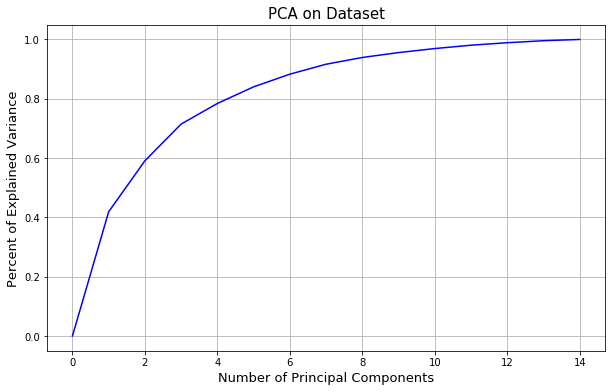

In [79]:
from sklearn import decomposition

pca = decomposition.PCA()
pca.fit_transform(x)

x_normalized = (x - x.mean())/x.std()
pca_normalized = decomposition.PCA()
pca_normalized.fit_transform(x_normalized)

plt.figure(figsize=(10,6))
plt.plot(np.cumsum([0] + list(pca_normalized.explained_variance_ratio_)), 'b')
plt.title("PCA on Dataset", fontsize=15)
plt.xlabel("Number of Principal Components", fontsize=13)
plt.ylabel("Percent of Explained Variance",fontsize=13)
plt.grid()

Training DummyClassifier on 4133 samples
             precision    recall  f1-score   support

          1       0.00      0.00      0.00       412
          2       0.00      0.00      0.00       429
          3       0.00      0.00      0.00       465
          4       0.26      1.00      0.42       466

avg / total       0.07      0.26      0.11      1772

Training LogisticRegression on 4133 samples
             precision    recall  f1-score   support

          1       0.47      0.61      0.53       412
          2       0.37      0.41      0.39       429
          3       0.39      0.19      0.26       465
          4       0.56      0.65      0.61       466

avg / total       0.45      0.46      0.44      1772

Training KNeighborsClassifier on 4133 samples
             precision    recall  f1-score   support

          1       0.43      0.52      0.47       412
          2       0.34      0.44      0.39       429
          3       0.37      0.30      0.33       465
          4   

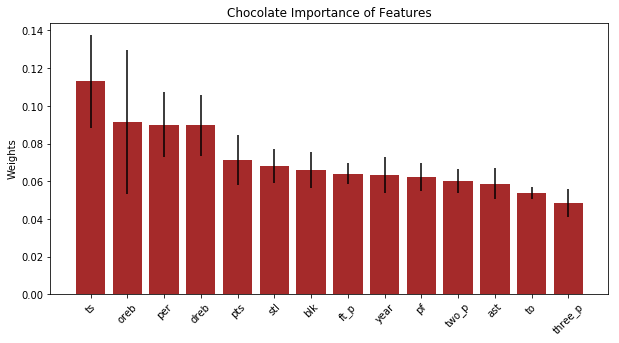

Training RandomForestClassifier on 4133 samples
             precision    recall  f1-score   support

          1       0.54      0.50      0.51       412
          2       0.35      0.44      0.39       429
          3       0.39      0.33      0.36       465
          4       0.62      0.62      0.62       466

avg / total       0.48      0.47      0.47      1772



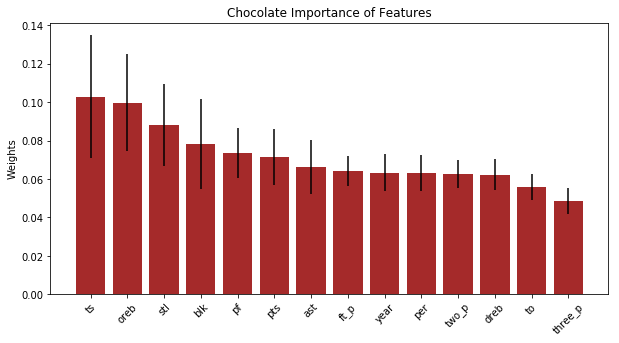

In [103]:
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC

def run_classifiers(xTr, xTe, yTr, yTe):
    dummy = DummyClassifier(strategy='most_frequent')
    rf = RandomForestClassifier()
    opt_rf = RandomForestClassifier(n_estimators=500, random_state=15)
    nb = GaussianNB()
    knn = KNeighborsClassifier()
    opt_knn = KNeighborsClassifier(n_neighbors=22)
    dt = DecisionTreeClassifier(max_depth=1)
    sgd = SGDClassifier()
    lr = LogisticRegression()
    svc = SVC()
    opt_svc = SVC(C = 10, gamma = 1, kernel = 'rbf')

    classifiers = [dummy, lr, knn, opt_knn, dt, svc, opt_svc, rf, opt_rf]
#     classifiers = [dummy, rf]
    # Sample 1%, 10%, 25%, 50%, and 100% of the training set
    sample_pcts = [100]
    sample_sizes = [int(len(xTr)*pct/100) for pct in sample_pcts]

    results = {}
    for classifier in classifiers:
        classifier_name = classifier.__class__.__name__
        results[classifier_name] = {}
        for sample_size in sample_sizes:
            results[classifier_name][sample_size] = predict(classifier, sample_size, xTr, yTr, xTe, yTe)
    
xTr, xTe, yTr, yTe = train_test_split(x, y_cl, test_size=0.3, random_state=1)

run_classifiers(xTr, xTe, yTr, yTe)

Training DummyClassifier on 4133 samples
             precision    recall  f1-score   support

          1       0.00      0.00      0.00       412
          2       0.00      0.00      0.00       429
          3       0.00      0.00      0.00       465
          4       0.26      1.00      0.42       466

avg / total       0.07      0.26      0.11      1772

Training RandomForestClassifier on 4133 samples
             precision    recall  f1-score   support

          1       0.45      0.48      0.46       412
          2       0.34      0.41      0.37       429
          3       0.36      0.32      0.34       465
          4       0.59      0.51      0.54       466

avg / total       0.43      0.43      0.43      1772



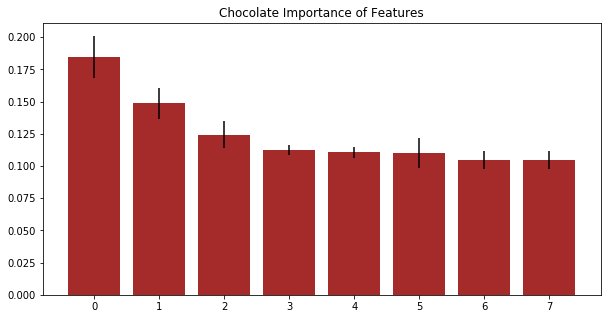

In [86]:
from sklearn import decomposition

# Run PCA
pca = decomposition.PCA(n_components=8)

xTr, xTe, yTr, yTe = train_test_split(x, y_cl, test_size=0.3, random_state=1)

xTr_pca = pca.fit_transform(xTr)
xTe_pca = pca.transform(xTe)

run_classifiers(xTr_pca, xTe_pca, yTr, yTe)

In [102]:
# Improve on KNN
from sklearn.neighbors import KNeighborsClassifier

params = {
    'n_neighbors': list(range(1, 30))
}

knn = KNeighborsClassifier()
grid_knn = GridSearchCV(knn, param_grid=params, scoring='accuracy', cv=5, n_jobs=-1)
grid_knn.fit(xTr, yTr)
grid_knn.best_params_

{'n_neighbors': 22}

In [ ]:
# Improve on Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer

params = {
    'n_estimators': [100, 200, 300, 500],
    'random_state': [5, 10, 15, 20, 30]
}

scorer = make_scorer(fbeta_score, beta=0.5, average='micro')

rf = RandomForestClassifier()
grid_rf = GridSearchCV(rf, param_grid=params, scoring=scorer, cv=5, n_jobs=-1)
grid_rf.fit(xTr, yTr)
grid_rf.best_params_

In [99]:
# Improve on SVM
from sklearn.svm import SVC

params = {
    'C': [0.1, 0.5, 1, 2, 10, 100],
    'kernel': ['rbf', 'linear'],
    'gamma': [0.01, 0.1, 0.5, 1, 5, 10]
}

svc = SVC()
grid_svc = GridSearchCV(svc, param_grid=params, scoring='accuracy', cv=5, n_jobs=-1)
grid_svc.fit(xTr, yTr)
grid_svc.best_params_

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

In [22]:
def plot_results(y_preds, yTe):
    fig, ax = plt.subplots(figsize=(10, 5))
    yTe, y_preds = data_sort(yTe, y_preds)
    ax.plot(yTe, 'blue')
    ax.plot(y_preds, 'r.')
    ax.autoscale_view()
    ax.grid = True

def predict_reg(model, sample_size, xTr, yTr, xTe, yTe):
    '''
        params:
        - model: model to fit
        - sample_size: number of samples to size
        - xTr: training features
        - yTr: training labels
        - xTe: testing features
        - yTe: testing labels
    '''
    print("Training {} on {} samples".format(model.__class__.__name__, sample_size))
    results = {}
    
    start = time.time()
    model = model.fit(xTr[:sample_size], yTr[:sample_size])
    end = time.time()

    results['train_time'] = end - start
    
    start = time.time()
    train_preds = model.predict(xTr[:300])
    test_preds = model.predict(xTe)
    end = time.time()
    
    results['prediction_time'] = end - start
    
    # Score by accuracy 1(pred_i != yTe_i)
    results['rmse_train'] = math.sqrt(mean_squared_error(yTr[:300], train_preds))
    results['rmse_test'] = math.sqrt(mean_squared_error(yTe, test_preds))

    print("{}: {}".format(model.__class__.__name__, results['rmse_test']))

    if model.__class__.__name__ == "RandomForestRegressor":
        try:
            importances = model.feature_importances_

            std = np.std([tree.feature_importances_ for tree in model.estimators_],
                         axis=0)
            indices = np.argsort(importances)[::-1]

            plt.figure(figsize=(10,5))
            plt.title("Importance of Features")
            plt.bar(range(xTr.shape[1]), importances[indices],
                     yerr=std[indices], align="center")
            plt.xticks(indices, xTr.columns, rotation=45)
            plt.ylabel("Weights")
            plt.show()
        except:
            pass
    
    return results

Training DummyRegressor on 4133 samples
DummyRegressor: 5366840.8523
Training KNeighborsRegressor on 4133 samples
KNeighborsRegressor: 3648595.86751
Training KNeighborsRegressor on 4133 samples
KNeighborsRegressor: 3605439.53758
Training DecisionTreeRegressor on 4133 samples
DecisionTreeRegressor: 4498822.25738
Training SGDRegressor on 4133 samples
SGDRegressor: 4051327.97678
Training LinearRegression on 4133 samples
LinearRegression: 3650656.33875
Training SVR on 4133 samples
SVR: 5366816.79797
Training SVR on 4133 samples
SVR: 4060242.69958
Training RandomForestRegressor on 4133 samples
RandomForestRegressor: 3477399.17633


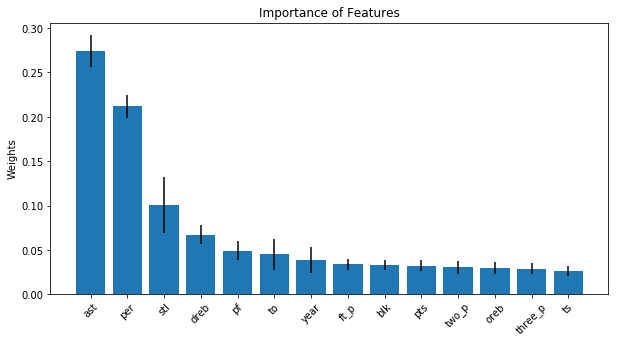

Training RandomForestRegressor on 4133 samples
RandomForestRegressor: 3223787.95076


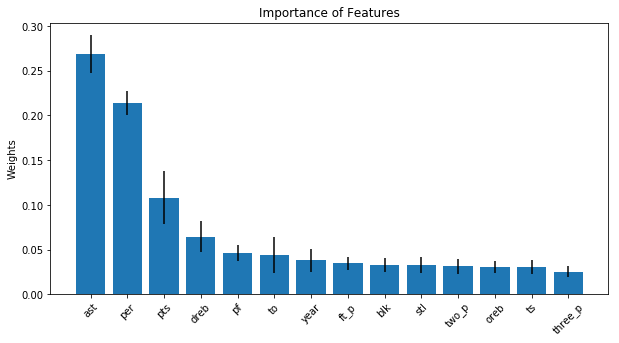

In [92]:
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.svm import SVR

def run_regressors(xTr, xTe, yTr, yTe):
    dummy = DummyRegressor(strategy='median')
    rf = RandomForestRegressor()
    opt_rf = RandomForestRegressor(n_estimators=250, random_state=30)
    knn = KNeighborsRegressor()
    opt_knn = KNeighborsRegressor(n_neighbors=8)
    dt = DecisionTreeRegressor(max_depth=1)
    sgd = SGDRegressor()
    lin_reg = LinearRegression()
    svr = SVR()
    opt_svr = SVR(C = 100000, gamma = 1, kernel = 'rbf')

    classifiers = [dummy, knn, opt_knn, dt, sgd, lin_reg, svr, opt_svr, rf, opt_rf]
#     classifiers = [opt_rf]
    # Sample 1%, 10%, 25%, 50%, and 100% of the training set
    sample_pcts = [100]
    sample_sizes = [int(len(xTr)*pct/100) for pct in sample_pcts]

    results = {}
    for classifier in classifiers:
        classifier_name = classifier.__class__.__name__
        results[classifier_name] = {}
        for sample_size in sample_sizes:
            results[classifier_name][sample_size] = predict_reg(classifier, sample_size, xTr, yTr, xTe, yTe)
    
    # return results
    
xTr, xTe, yTr, yTe = train_test_split(x, y, test_size=0.3, random_state=1)
run_regressors(xTr, xTe, yTr, yTe)

Training DummyRegressor on 4133 samples
DummyRegressor: 5366840.8523
Training KNeighborsRegressor on 4133 samples
KNeighborsRegressor: 3669846.38382
Training KNeighborsRegressor on 4133 samples
KNeighborsRegressor: 3628418.86376
Training DecisionTreeRegressor on 4133 samples
DecisionTreeRegressor: 4629516.24063
Training SGDRegressor on 4133 samples
SGDRegressor: 4028638.36435
Training LinearRegression on 4133 samples
LinearRegression: 3756947.34692
Training SVR on 4133 samples
SVR: 5366800.59549
Training SVR on 4133 samples
SVR: 4059958.45922
Training RandomForestRegressor on 4133 samples
RandomForestRegressor: 3571983.1955
Training RandomForestRegressor on 4133 samples
RandomForestRegressor: 3383830.49749


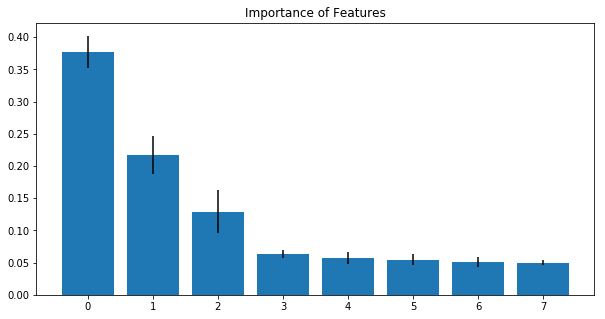

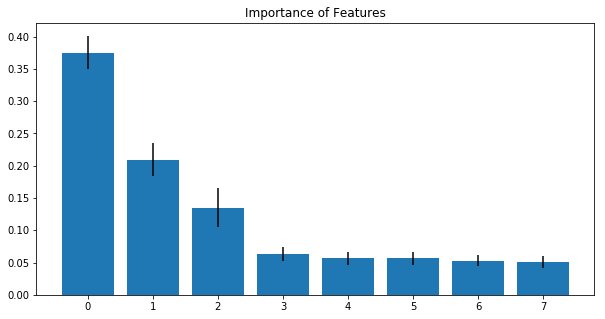

In [93]:
from sklearn import decomposition

# Run PCA
pca = decomposition.PCA(n_components=8)

xTr, xTe, yTr, yTe = train_test_split(x, y, test_size=0.3, random_state=1)

xTr_pca = pca.fit_transform(xTr)
xTe_pca = pca.transform(xTe)

run_regressors(xTr_pca, xTe_pca, yTr, yTe)

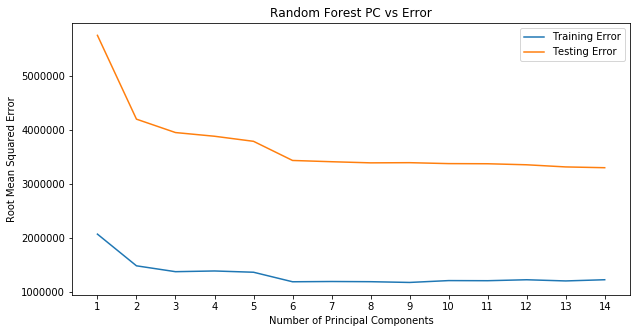

In [77]:
plt.figure(figsize=[10, 5])
plt.xlabel('Number of Principal Components')
plt.xticks(list(range(1, 15)))
plt.ylabel("Root Mean Squared Error")
plt.title('Random Forest PC vs Error')
tr, = plt.plot(train_err)
te, = plt.plot(test_err)
plt.legend([tr, te], ["Training Error", "Testing Error"])

In [ ]:
# Improve on SVM
from sklearn.svm import SVR

params = {
    'C': [0.1, 1, 10, 100, 1000, 10000, 100000],
    'kernel': ['poly','rbf'],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}
# {'kernel': 'rbf', 'C': 100000, 'gamma': 1}
svr = SVR()
grid_svr = GridSearchCV(svr, param_grid=params, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
grid_svr.fit(xTr, yTr)
print(grid_svr.best_params_)

In [ ]:
# Improve on KNN
from sklearn.neighbors import KNeighborsRegressor

params = {
    'n_neighbors': list(range(1, 25))
}

knn = KNeighborsRegressor()
grid = GridSearchCV(knn, param_grid=params, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
grid.fit(xTr, yTr)
print(grid.best_params_)

In [ ]:
# Improve on Random Forest
from sklearn.ensemble import RandomForestRegressor

params = {
    'n_estimators': [100, 500],
    'max_features': ['auto', 10],
    'random_state': [30]
}

rf = RandomForestRegressor()
grid = GridSearchCV(rf, param_grid=params, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
grid.fit(xTr, yTr)
print(grid.best_params_)